# 66ers - All products
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 19 # 66ers
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(2155, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            2155 non-null   int64  
 1   dimCustomerMasterId     2155 non-null   int64  
 2   customerNumber          2155 non-null   object 
 3   year                    2155 non-null   int64  
 4   productGrouping         2155 non-null   object 
 5   totalSpent              2155 non-null   float64
 6   recentDate              2155 non-null   object 
 7   attendancePercent       2155 non-null   float64
 8   renewedBeforeDays       2155 non-null   int64  
 9   isBuyer                 2155 non-null   object 
 10  source_tenure           2155 non-null   int64  
 11  tenure                  2155 non-null   int64  
 12  distToVenue             2155 non-null   float64
 13  totalGames              2155 non-null   int64  
 14  recency                 2155 non-null   

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["year",
            "isNextYear_Buyer",
            "productGrouping",
            "dimCustomerMasterId",
        "totalSpent",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "totalGames",
        "recency",
        "missed_games_1",
        "missed_games_2",
        "is_Lockdown",
        "NumberofGamesPerSeason"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (1615, 15)
Unseen Data For Predictions: (285, 15)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
     "totalSpent",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "totalGames",
        "recency",
        "missed_games_1",
        "missed_games_2",
        "is_Lockdown",
        "NumberofGamesPerSeason"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7056,0.7453,0.5522,0.6855,0.6088,0.3779,0.3854,0.3170
xgboost,Extreme Gradient Boosting,0.6939,0.7599,0.6218,0.6394,0.6286,0.3686,0.3703,0.2730


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6667,0.7425,0.4828,0.6364,0.5490,0.2925,0.2995
1,0.6739,0.7192,0.5690,0.6226,0.5946,0.3228,0.3237
2,0.7007,0.7099,0.6667,0.6333,0.6496,0.3887,0.3891
3,0.7299,0.7800,0.5614,0.7273,0.6337,0.4253,0.4343
4,0.6788,0.6783,0.4386,0.6757,0.5319,0.3039,0.3204
5,0.6642,0.7232,0.4912,0.6222,0.5490,0.2874,0.2925
6,0.7372,0.7579,0.5614,0.7442,0.6400,0.4394,0.4502
7,0.7299,0.7447,0.5439,0.7381,0.6263,0.4223,0.4344
8,0.7664,0.8136,0.6897,0.7407,0.7143,0.5172,0.5181
9,0.7080,0.7835,0.5172,0.7143,0.6000,0.3792,0.3915


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(255, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
1900,19,325195514,8176194,2021,Mini Plan,198.0,2021-09-12,0.909091,61,TRUE,...,0,0,0.0,1,132,0,0,0,0.5553,0.4447
1901,19,325195515,8538916,2021,Mini Plan,1261.5,2021-09-12,0.657534,50,TRUE,...,0,0,0.0,1,132,0,0,0,0.6688,0.3312
1902,19,325195543,11215672,2021,Mini Plan,672.0,2021-08-13,0.395833,71,TRUE,...,0,0,0.0,1,132,0,0,0,0.8162,0.1838
1903,19,325195566,8339203,2021,Mini Plan,290.0,2021-08-14,0.600000,65,TRUE,...,0,0,0.0,1,132,0,0,0,0.7212,0.2788
1904,19,325195728,8399228,2021,Mini Plan,348.0,2021-08-14,0.916667,74,TRUE,...,0,0,0.0,1,132,0,0,0,0.6050,0.3950


In [11]:
new_predictions["Label"].value_counts()

0    239
1     16
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.2, 0.4]       120
(-0.001, 0.2]     85
(0.4, 0.6]        41
(0.6, 0.8]         9
(0.8, 1.0]         0
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

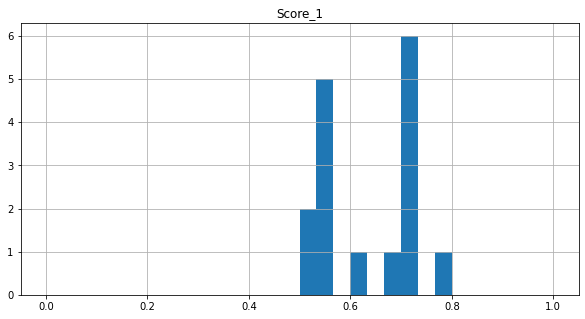

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

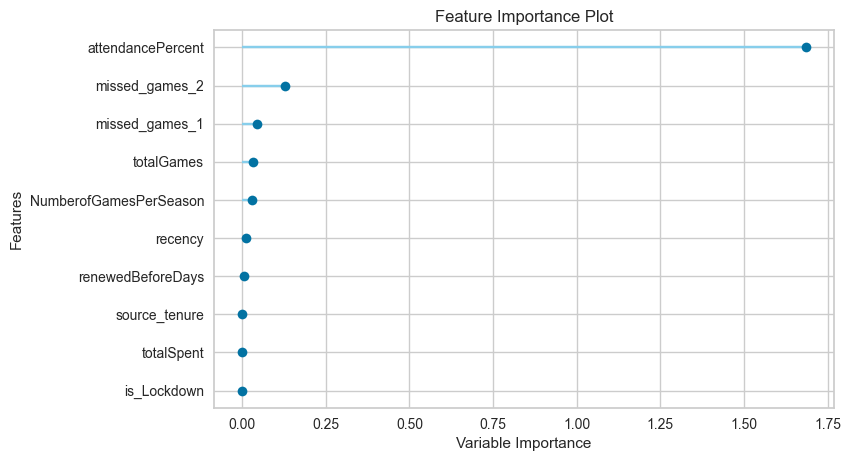

In [14]:
plot_model(best_model, plot='feature')

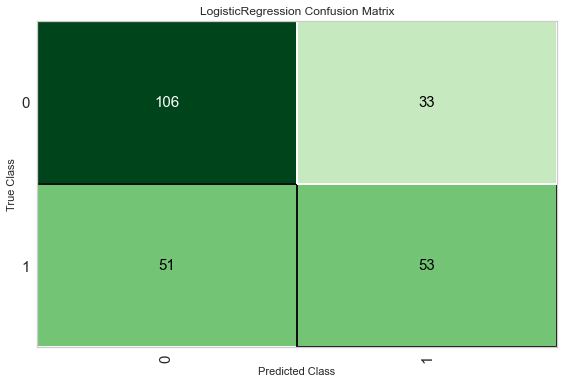

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?